In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import skew
import statsmodels.api as sm
import os
import time
import warnings

warnings.filterwarnings("ignore")

C:\Users\willy\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# XGBoost
## Modelo de Predicción de Series de Tiempo de Delitos Informáticos

## Preprocesamiento de los datos
Carga de los datos, definición de carpetas para guardar resultados (tablas e imágenes) y creación del dataframe.

In [2]:
# Crear carpeta para guardar las tablas en la ruta especificada
output_dir = 'Ruta_para_guardar_resultados_xgb/XGB'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Cargar el archivo Excel
file_path = 'Ruta_base_de_datos/DI_2019_2024.xlsx'
xls = pd.ExcelFile(file_path)
data = pd.read_excel(xls, sheet_name='Hoja1')

# Crear un DataFrame con solo los campos 'departamento_hecho', 'fecha_hecho' y 'delito_agrupado'
df = data[['departamento_hecho', 'fecha_hecho', 'delito_agrupado']]

# Filtrar los registros hasta el 5 de mayo de 2024
df = df[df['fecha_hecho'] <= '2024-05-05']

# Añadir una nueva columna 'categoria_delito'
df['categoria_delito'] = df['delito_agrupado'].apply(lambda x: 1 if x in ['Hurto por medios informáticos', 'Transferencia no consentida'] else 0)

# Asegurarse de que 'fecha_hecho' es de tipo datetime
df['fecha_hecho'] = pd.to_datetime(df['fecha_hecho'])

# Establecer 'fecha_hecho' como índice
df.set_index('fecha_hecho', inplace=True)

## Definición de funciones

In [3]:
# Función para crear lags
def create_lags(df, lags):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['Casos_log'].shift(lag)
    return df

# Función para evaluar heterocedasticidad
def perform_breusch_pagan_test(series):
    X = sm.add_constant(range(len(series)))  # Agregar una constante (intercepto)
    model = sm.OLS(series, X).fit()
    bp_test = het_breuschpagan(model.resid, model.model.exog)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    return dict(zip(labels, bp_test))

# Función para evaluar sesgo
def skewness_test(series):
    skewness_value = skew(series)
    tipo_sesgo = "Sesgada a la derecha" if skewness_value > 0 else "Sesgada a la izquierda"
    return skewness_value, tipo_sesgo

# RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

# Función para calcular la distancia Hellinger
def hellinger_distance(p, q):
    return np.sqrt(1 - np.sum(np.sqrt(p * q)))

## Función principal para procesar las series de tiempo de todos los departamentos por categoría de delito

In [4]:
# Función para procesar cada categoría de delito
def process_category(df, categoria_delito, title, filename_prefix):
    df_filtered = df[df['categoria_delito'] == categoria_delito]
    departamentos = df_filtered['departamento_hecho'].value_counts().index

    # Crear subplots
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20), constrained_layout=True)
    fig.suptitle(title, fontsize=18)

    resultados_het = []
    resultados_sesgo = []
    resultados_metricas = []

    for i, departamento in enumerate(departamentos):
        df_depto = df_filtered[df_filtered['departamento_hecho'] == departamento]

        # Resamplear los datos a frecuencia semanal, sumando los valores
        df_week = df_depto.resample('W-SUN').size().reset_index(name='Casos')
        df_week.set_index('fecha_hecho', inplace=True)

        # Aplicar transformación logarítmica
        df_week['Casos_log'] = np.log(df_week['Casos'] + 1)

        # Crear lags
        df_week = create_lags(df_week, lags=4)
        df_week.dropna(inplace=True)

        # Separar en conjunto de entrenamiento y prueba
        train = df_week[df_week.index.year < 2024]
        test = df_week[df_week.index.year == 2024]

        # Separar características (X) y etiquetas (y)
        X_train = train.drop(columns=['Casos', 'Casos_log'])
        y_train = train['Casos_log']
        X_test = test.drop(columns=['Casos', 'Casos_log'])
        y_test = test['Casos_log']

        # Crear DMatrices para XGBoost
        dtrain = xgb.DMatrix(data=X_train, label=y_train)
        dtest = xgb.DMatrix(data=X_test, label=y_test)

        # Definir el modelo
        model = xgb.XGBRegressor(objective='reg:squarederror')

        # Definir la grilla de parámetros
        param_grid = {
            'max_depth': [3, 5, 7],
            'eta': [0.01, 0.1, 0.3],
            'n_estimators': [100, 200, 300]
        }

        # Configurar GridSearch con TimeSeriesSplit
        tscv = TimeSeriesSplit(n_splits=5)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)

        # Entrenar el modelo
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()

        best_model = grid_search.best_estimator_

        # Predecir valores
        y_pred_log = best_model.predict(X_test)
        y_pred = np.exp(y_pred_log) - 1
        y_test_exp = np.exp(y_test) - 1

        # Calcular métricas
        mean_df=df_week['Casos'].mean()
        rmse_value = np.sqrt(mean_squared_error(y_test_exp, y_pred))
        mae_value = mean_absolute_error(y_test_exp, y_pred)
        rmsle_value = rmsle(y_test_exp, y_pred)
            
        # Calcular la Hellinger Distance usando y_test_exp y y_pred
        p = y_test_exp / np.sum(y_test_exp)
        q = y_pred / np.sum(y_pred)
        hellinger_value = hellinger_distance(p, q)

        # Pruebas de heterocedasticidad y sesgo
        bp_test_results = perform_breusch_pagan_test(y_train)
        skewness_value, tipo_sesgo = skewness_test(y_train)

        # Guardar resultados
        resultados_het.append([departamento, bp_test_results['LM-Test p-value'], bp_test_results['F-Test p-value']])
        resultados_sesgo.append([departamento, skewness_value, tipo_sesgo])
        resultados_metricas.append([departamento, mean_df, rmse_value, mae_value,  rmsle_value, hellinger_value, end_time - start_time])

        # Graficar los resultados en el subplot correspondiente
        row = i // 2
        col = i % 2
        axes[row, col].plot(train.index, np.exp(train['Casos_log']) - 1, label='Entrenamiento', lw=1.5)
        axes[row, col].plot(y_test_exp.index, y_test_exp, label='Prueba', lw=1.5)
        axes[row, col].plot(pd.Series(y_pred, index=y_test.index), label='Predicción', lw=1.5)
        axes[row, col].set_title(departamento, fontsize=14)
        axes[row, col].set_xlabel('Año', fontsize=12)
        axes[row, col].set_ylabel('Casos', fontsize=12)
        axes[row, col].legend(loc='upper left', fontsize=10)

    # Ajustar diseño y guardar la gráfica
    plt.savefig(f'{output_dir}/{filename_prefix}_grafica.png')
    plt.show()

    # Crear DataFrame para los resultados y guardarlos en hojas de Excel
    with pd.ExcelWriter(f'{output_dir}/{filename_prefix}_resultados.xlsx') as writer:
        # Resultados de heterocedasticidad
        resultados_het_df = pd.DataFrame(resultados_het, columns=['Departamento', 'LM-Test p-value', 'F-Test p-value'])
        resultados_het_df.to_excel(writer, sheet_name='Heterocedasticidad', index=False)

        # Resultados de sesgo
        resultados_sesgo_df = pd.DataFrame(resultados_sesgo, columns=['Departamento', 'Skewness', 'Tipo de Sesgo'])
        resultados_sesgo_df.to_excel(writer, sheet_name='Sesgo', index=False)

        # Resultados de métricas
        resultados_metricas_df = pd.DataFrame(resultados_metricas, columns=['Departamento', 'Media', 'RMSE', 'MAE', 'RMSLE', 'Distancia Hellinger', 'Tiempo de entrenamiento'])
        resultados_metricas_df.to_excel(writer, sheet_name='Métricas', index=False)

## Procesamiento de datos 'categoria_delito' = 0, 
## 'Atentados contra la confidencialidad, la integridad y la disponibilidad de los datos y de SI'

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


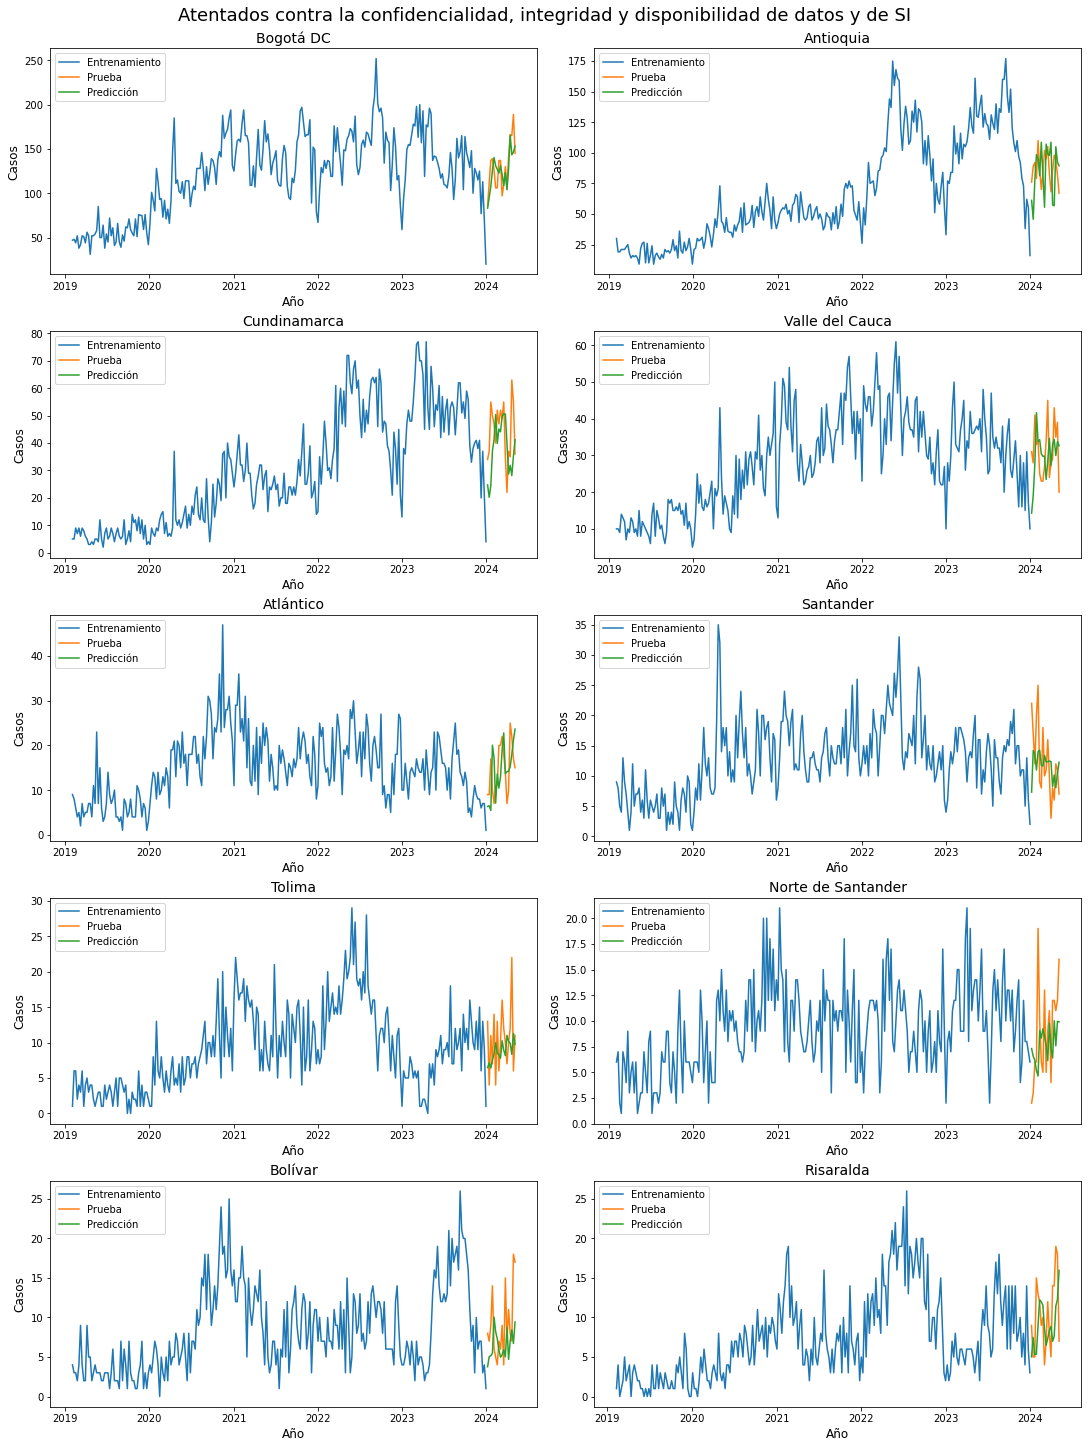

In [5]:
# Procesar datos de 'categoria_delito' = 0
process_category(df, 0, 'Atentados contra la confidencialidad, integridad y disponibilidad de datos y de SI', 'categoria_0_XGB')

## Procesamiento de datos 'categoria_delito' = 1,
## 'Atentados informáticos y otras infracciones'

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits


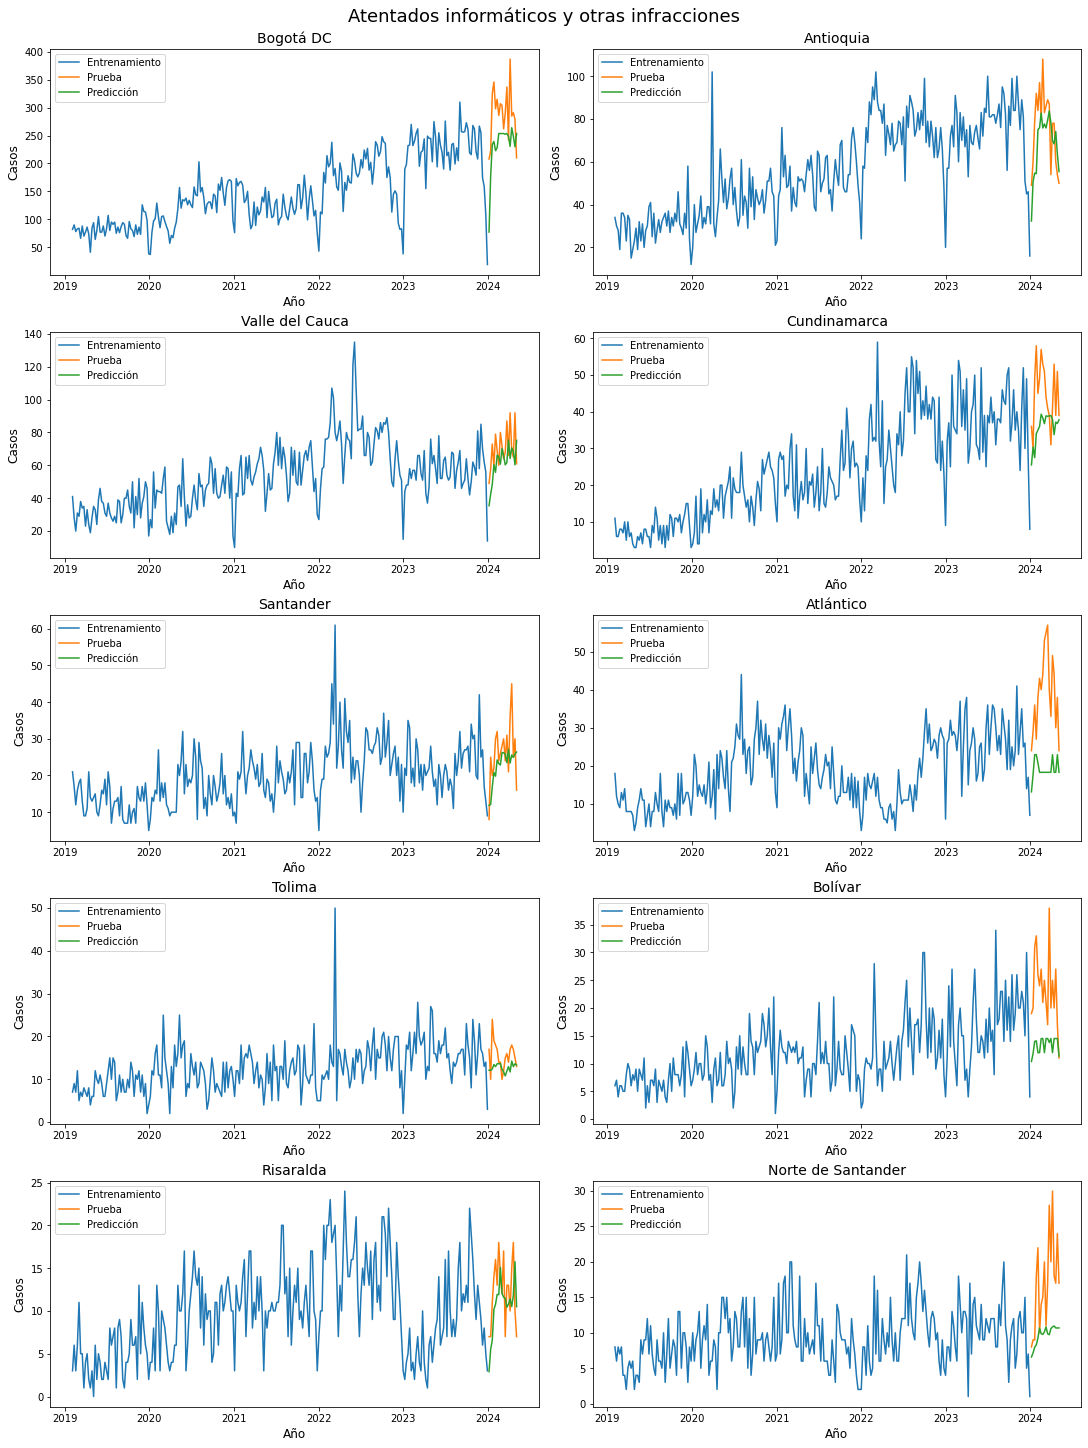

In [6]:
# Procesar datos de 'categoria_delito' = 1
process_category(df, 1, 'Atentados informáticos y otras infracciones', 'categoria_1_XGB')